# Training Amazon SageMaker models by using the Deep Graph Library with PyTorch backend

## Setup

Define a few variables that are needed later in the example.

In [1]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
import boto3

# Setup session
sess = sagemaker.Session()

# S3 bucket for saving code and model artifacts.
# Feel free to specify a different bucket here.
bucket = sess.default_bucket()

# IAM execution role that gives Amazon SageMaker access to resources in your AWS account.
# You can use the Amazon SageMaker Python SDK to get the role from the notebook environment.
role = get_execution_role()

In [2]:
stack_name = 'gnn-proteins' # name of CloudFormation stack

## The training script

In [3]:
# !cat src/main.py

In [4]:
# copy the certificate bundle for SM training jobs
!cp rds-combined-ca-bundle.pem src/

## Set up SageMaker's estimator

In [5]:
from utils import get_secret

In [6]:
secrets = get_secret(stack_name)

In [7]:
# secrets

In [8]:
ec2 = boto3.client('ec2')

In [9]:
# find NAT subnet ID 
resp = ec2.describe_subnets(
    Filters=[{'Name': 'tag:Name', 'Values': ['{}-NATSubnet'.format(stack_name)]}]
)
nat_subnet_id = resp['Subnets'][0]['SubnetId']

In [10]:
# find security group ids
resp = ec2.describe_security_groups(
    Filters=[{
        'Name': 'tag:Name', 
        'Values': ['{}-SG-DocumentDB'.format(stack_name)]
    }])
sg_id = resp['SecurityGroups'][0]['GroupId']

In [11]:
from sagemaker.pytorch import PyTorch

CODE_PATH = "main.py"

params = {
    'patience': 5, 
    'n-epochs': 200,
    'batch-size': 64,
    'db-host': secrets['host'],
    'db-username': secrets['username'], 
    'db-password': secrets['password'], 
    'db-port': secrets['port'],
    'knn': 4,
}

estimator = PyTorch(
    entry_point=CODE_PATH,
    source_dir='src',
    role=role,
    instance_count=1,
    instance_type="ml.p3.2xlarge", # 'ml.c4.2xlarge' for CPU
    framework_version="1.7.1",
    py_version="py3",
    hyperparameters=params,
    sagemaker_session=sess,
    subnets=[nat_subnet_id], 
    security_group_ids=[sg_id],
)

In [12]:
# estimator.get_vpc_config()

## Running the Training Job

In [13]:
estimator.fit()

## Load the trained model and evaluate

In [14]:
estimator.model_data

In [15]:
from utils import load_sagemaker_model_artifact

In [16]:
# load the state_dict from SageMaker's model artifact
state_dict = load_sagemaker_model_artifact(
    bucket, 
    estimator.model_data.split(bucket)[1].lstrip('/')
)
state_dict.keys()

dict_keys(['model_state_dict'])

In [17]:
state_dict['model_state_dict'].keys()

odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'gate_nn.weight', 'gate_nn.bias', 'gap.gate_nn.weight', 'gap.gate_nn.bias', 'output.weight', 'output.bias'])

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.utils.data as data

import numpy as np

from src.model import GCN
from src.dataset import ProteinDataset, \
    collate_protein_graphs, d1_to_index, convert_to_graph

Using backend: pytorch


In [19]:
# initialize a GCN model
dim_nfeats = len(d1_to_index)
n_classes = 1
model = GCN(dim_nfeats, 16, n_classes)

In [20]:
# load the learned parameters
model.load_state_dict(state_dict['model_state_dict'])

<All keys matched successfully>

## Load test dataset

In [21]:
uri = "mongodb://{}:{}@{}:{}/?tls=true&tlsCAFile=rds-combined-ca-bundle.pem&replicaSet=rs0&readPreference=secondaryPreferred&retryWrites=false".format(
    secrets["username"],
    secrets["password"],
    secrets["host"],
    secrets["port"],
)
    
test_dataset = ProteinDataset([
        {"$match": {"$and": [{"is_AF": {"$exists": True}}, {"split": "test"}]}},
        {"$project": {"y": "$is_AF"}},
    ],
    db_uri=uri,
    db_name="proteins",
    collection_name="proteins",
)
test_loader = data.DataLoader(
    test_dataset,
    batch_size=64,
    collate_fn=collate_protein_graphs,
)

### Evaluate model performance on the entire test set

In [22]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
num_correct = 0
num_tests = 0
model.eval()
with torch.no_grad():
    for batched_graph, labels in test_loader:
        batched_graph = batched_graph.to(device)
        labels = labels.to(device)
        logits = model(batched_graph)
        preds = (logits.sigmoid() > 0.5).to(labels.dtype)
        num_correct += (preds == labels).sum().item()
        num_tests += len(labels)

print('Test accuracy: {:.6f}'.format(num_correct / num_tests))

Test accuracy: 0.743265


### Model interpretation with attention scores

In [23]:
# connection to DocDB
from pymongo import MongoClient
client = MongoClient(uri, connect=False)
collection = client['proteins']['proteins']

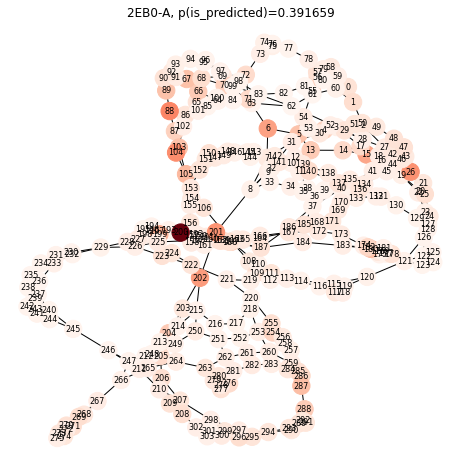

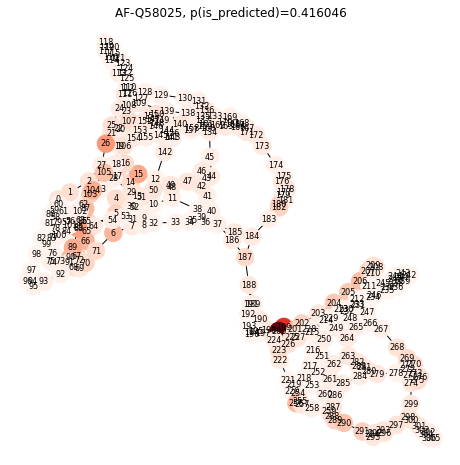

In [24]:
# id's of a pair of protein structures that are 
# AlphaFold prediected and experimental
pair = ['AF-Q58025', '2EB0-A']

cur = collection.find(
    {'id': {'$in': pair}},
)

for doc in cur:
    # convert document to dgl.graph object
    graph = convert_to_graph(doc, k=4)
    with torch.no_grad():
        # make prediction
        pred = model(graph).sigmoid()
        # calculate attention scores for a protein graph
        attn = model.attention_scores(graph)

    pred = pred.item()
    attn = attn.numpy()
    
    # convert dgl.graph to networkx graph for visualization
    graph = graph.to_networkx().to_undirected()
    # calculate graph layout
    pos = nx.spring_layout(graph, iterations=200)
    # draw:
    fig, ax = plt.subplots(figsize=(8, 8))
    nx.draw(
        graph, 
        pos, 
        node_color=attn.flatten(),
        cmap='Reds',
        with_labels=True, 
        font_size=8,
        ax=ax
    )
    ax.set(title='{}, p(is_predicted)={:.6f}'.format(doc['id'], pred))
    plt.show()